# Quickstart Example with Synthetic Recommender Simulation (Customization)
This notebook provides an example of customizing the Recommender environment.

This example on the Synthetic Recommender Simulation consists of the following 3 steps:
1. Setup Synthetic Recommender Simulation Environment and Interacting Online RL Agent
2. Standardized Environment
3. Customize Environmental Configuration

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations.  

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [4]:
# import SCOPE-RL modules
import scope_rl
from scope_rl.policy import OnlineHead

# import recgym modules
from recgym import RECEnv
from recgym import BaseUserModel

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy

# import from other libraries
import gym

from sklearn.utils import check_random_state
from sklearn.utils import check_scalar

In [5]:
from dataclasses import dataclass
from typing import Tuple, Union, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(scope_rl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345
random_ = check_random_state(random_state)

## 1. Setup Synthetic Recommender Simulation Environment and Interacting Online RL Agent
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for Recommendation
In recommendation, the objective of the RL agent is to maximize reward

We often formulate this recommendation problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: 
   - A vector representing user preference.  The preference changes over time in an episode by the actions presented by the RL agent.
   - When the true state is unobservable, the agent uses observation instead of state.
- `action`: Indicating which item to present to the user.
- `reward`: User engagement signal. Either binary or continuous.

Let's see how it works!

In [8]:
# setup environment
env = RECEnv(random_state=random_state)

In [9]:
# define a random agent
agent = OnlineHead(
    DiscreteRandomPolicy(),
    name="random",
)
agent.build_with_env(env)

In [10]:
print(env.action_space)
print(env.observation_space)

Discrete(5)
Box(-1.0, 1.0, (5,), float64)


In [11]:
import scope_rl
from scope_rl.ope.online import calc_on_policy_policy_value
# calculate on-policy policy value
on_policy_performance = calc_on_policy_policy_value(
  env,
  agent,
  n_trajectories=100,
  random_state=12345
)

[calculate on-policy policy value]: 100%|███| 100/100 [00:00<00:00, 2895.96it/s]


In [12]:
print(on_policy_performance)

-0.46043943268113696


In [13]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.sample_action_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [14]:
# state 
print(obs.shape)
print(obs)

(5,)
[-0.04552487  0.1208106   0.11597855  0.14365492 -0.15756327]


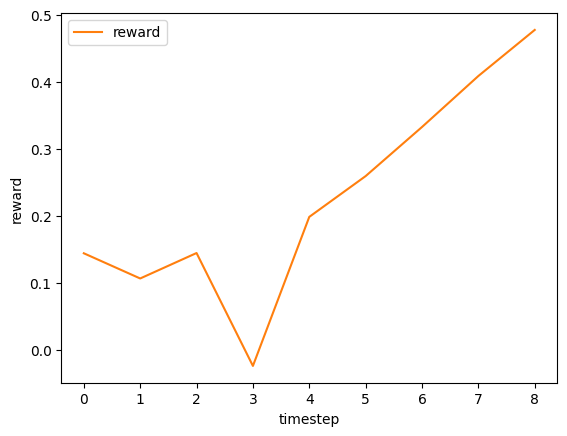

In [15]:
# let's visualize the transition of reward
def visualize_interaction_on_environment(env, agent):
    obs, info = env.reset()
    done = False
    reward_list = []

    while not done:
        action = agent.sample_action_online(obs)
        obs, reward, done, truncated, info = env.step(action)
        reward_list.append(reward)

    # plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(reward_list[:-1], label='reward', color='tab:orange')
    ax1.set_xlabel('timestep')
    ax1.set_ylabel('reward')
    ax1.legend(loc='upper left')
    plt.show()
    
visualize_interaction_on_environment(env, agent)

## 1. Standardized Environment

We provide standardize recommender environment

In [16]:
env = gym.make('RECEnv-v0')

## 2. Customize Environmental Configuration
Now, we customize the recommender simulation environment.

We have the following environmental configurations:
- `step_per_episode`: Number of timesteps in an episode.
- `n_items`: Number of items used in the recommender system.
- `n_users`: Number of users used in the recommender system.
- `item_feature_dim`: Dimension of the item feature vectors.
- `user_feature_dim`: Dimension of the user feature vectors.
- `item_feature_vector`: Feature vectors that characterize each item.
- `user_feature_vector`: Feature vectors that characterize each user.
- `reward_type`: Reward type.
- `reward_std`: Noise level of the reward. Applicable only when reward_type is "continuous".
- `obs_std`: Noise level of the state observation.
- `UserModel`: User model that defines the user prefecture dynamics and reward function.
- `random_state`: Random state.

#### Case 1. Customizing the Basic Setup

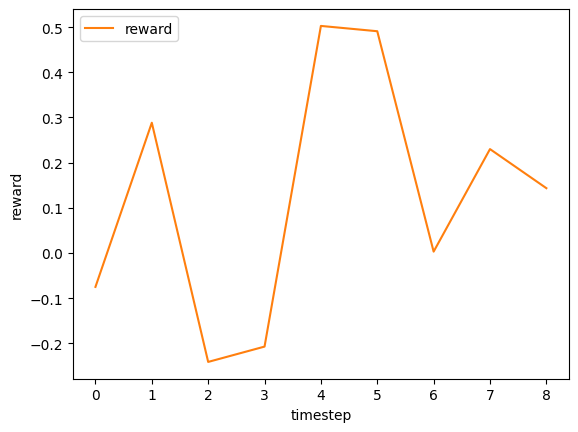

In [17]:
env = RECEnv(
    step_per_episode=10,
    n_items=100,
    n_users=100,
    item_feature_dim=5,
    user_feature_dim=5,
    reward_type="continuous",  # "binary"
    reward_std=0.3,
    obs_std=0.3,
    random_state=12345,
)
visualize_interaction_on_environment(env, agent)

#### Case 2. Defining the Items and Users

In [18]:
# we use the following items for recommendation
item_features = np.sign(random_.normal(size=(100, 5))).astype(int)
item_names, feature_names = [f"ad{i+1}" for i in range(100)], [f"feature{i+1}" for i in range(5)]
item_df = pd.DataFrame(item_features, columns=feature_names, index=item_names)
item_df

,feature1,feature2,feature3,feature4,feature5
ad1,-1,1,-1,-1,1
ad2,1,1,1,1,1
ad3,1,-1,1,1,1
ad4,1,-1,-1,1,-1
ad5,-1,1,1,-1,-1
...,...,...,...,...,...
ad96,1,-1,-1,-1,1
ad97,1,1,-1,1,1
ad98,-1,-1,1,1,-1
ad99,-1,1,-1,1,1


In [19]:
# we assume that the following 100 users 
user_features = np.sign(random_.normal(size=(100, 5))).astype(int)
user_names, feature_names = [f"user{i+1}" for i in range(100)], [f"feature{i+1}" for i in range(5)]
user_df = pd.DataFrame(user_features, columns=feature_names, index=user_names)
user_df

,feature1,feature2,feature3,feature4,feature5
user1,-1,-1,-1,1,1
user2,-1,-1,1,1,-1
user3,-1,-1,1,1,-1
user4,1,1,1,1,1
user5,-1,-1,1,1,1
...,...,...,...,...,...
user96,-1,-1,-1,-1,1
user97,1,-1,1,1,-1
user98,1,-1,1,-1,-1
user99,-1,1,-1,1,-1


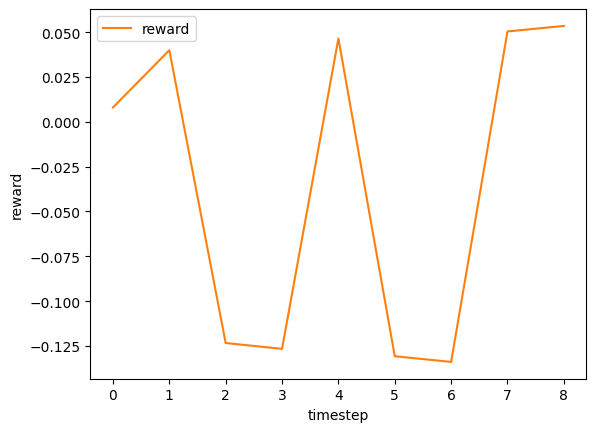

In [20]:
# using the above data, we can simulate an recommendation as follows
env = RECEnv(
        n_items=100,
        n_users=100,
        item_feature_dim=5,
        user_feature_dim=5,
        item_feature_vector=item_features,
        user_feature_vector=user_features,
        random_state = 12345,
)
visualize_interaction_on_environment(env, agent)

#### Case 3. Using Customized UserModel

In [21]:
@dataclass
class CustomizedUserModel(BaseUserModel):
    user_feature_dim: int
    item_feature_dim: int
    reward_type: str = "continuous"  # "binary"
    reward_std: float = 0.0
    random_state: Optional[int] = None

    def __post_init__(self):
        self.random_ = check_random_state(self.random_state)
        self.coef = self.random_.normal(size=(self.user_feature_dim, self.item_feature_dim))

    def user_preference_dynamics(
        self,
        state: np.ndarray,
        action: Union[int, np.ndarray],
        item_feature_vector: np.ndarray,
        alpha: float = 1.0,
    ) -> np.ndarray:
        coefficient = state.T @ self.coef @ item_feature_vector[action]
        state = state + alpha * coefficient * item_feature_vector[action]
        state = state / np.linalg.norm(state, ord=2)
        return state

    def reward_function(
        self,
        state: np.ndarray,
        action: Union[int, np.ndarray],
        item_feature_vector: np.ndarray,
    ) -> float:
        logit = state.T @ self.coef @ item_feature_vector[action]
        reward = (
            logit if self.reward_type == "continuous" else sigmoid(logit)
        )

        if self.reward_type == "discrete":
            reward = self.random_.binominal(1, p=reward)

        return reward

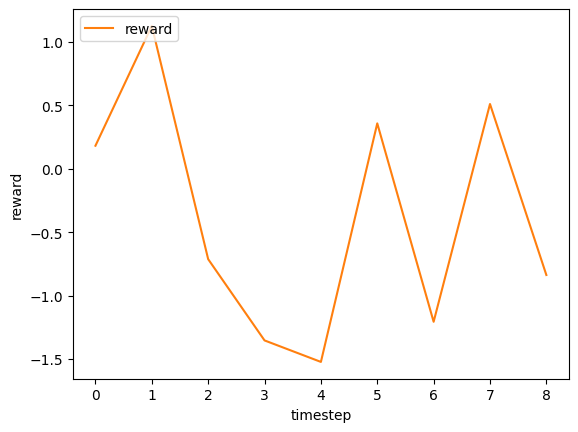

In [22]:
# setup environment
env = RECEnv(
    UserModel=CustomizedUserModel,
    random_state=12345
)
visualize_interaction_on_environment(env, agent)

For data collection and visualization, please refer to [examples/quickstart/rec/rec_synthetic_data_collection.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_data_collection.ipynb). 

For offline RL and OPE, please refer to [examples/quickstart/rec/rec_synthetic_discrete_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_discrete_basic.ipynb) and [examples/quickstart/rec/rec_synthetic_continuous_basic.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_continuous_basic.ipynb).

For advanced topics regarding OPE and OPS, please refer to [examples/quickstart/rec/rec_synthetic_discrete_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_basic_advanced.ipynb) and [examples/quickstart/rec/rec_synthetic_continuous_advanced.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart/rec/rec_synthetic_continuous_advanced.ipynb).

## Reference
- Sarah Dean and Jamie Morgenstern. \
"Preference Dynamics Under Personalized Recommendations.", 2022.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- David Rohde, Stephen Bonner, Travis Dunlop, Flavian Vasile, Alexandros Karatzoglou. \
"RecoGym: A Reinforcement Learning Environment for the Problem of Product Recommendation in Online Advertising." 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.